In [7]:
import sympy
from sympy import symbols, exp, simplify, diff

# ----------------------------------------------------------------------------
# 1) Define symbolic variables for two intervals
# ----------------------------------------------------------------------------
t0, t1, t2 = symbols('t0 t1 t2', positive=True)           # interval boundaries
dt1, dt2 = symbols('dt1 dt2', positive=True)           # interval boundaries
sigma0, sigma1 = symbols('sigma0 sigma1', positive=True)  # densities

# ----------------------------------------------------------------------------
# 2) Symbolic versions of your moment functions and the state updater
# ----------------------------------------------------------------------------
def moment_0_int(a, b, s1):
    # (1 - exp(s1*(a-b)))/s1
    return (1 - exp(s1*(a-b))) / s1

def moment_1_int(a, b, s1):
    # (a*s1 - (b*s1 + 1)*exp(s1*(a - b)) + 1)/s1^2
    return (a*s1 - (b*s1 + 1)*exp(s1*(a - b)) + 1) / (s1**2)

def self_dist(a, b, s):
    # ds = s*(a-b)
    # (2*s*(a-b)*exp(ds) + 1 - exp(2*ds)) / s^3
    ds = s*(a - b)
    return (2*s*(a-b)*exp(ds) + 1 - exp(2*ds)) / (s**3)

def update_distortion_state_int(state, tA, tB, s):
    """
    state = (x, y, z, w, v, T)
    tA, tB = interval boundaries
    s = density
    """
    x, y, z, w, v, T = state
    m0 = T * moment_0_int(tA, tB, s)
    m1 = T * moment_1_int(tA, tB, s)

    new_z = z + m0
    new_w = w + m1
    new_x = x + z*m1
    new_y = y + w*m0
    new_v = v + T**2 * self_dist(tA, tB, s)

    alpha = 1 - exp(-s*(tB - tA))
    new_T = T*(1 - alpha)

    return (new_x, new_y, new_z, new_w, new_v, new_T)

# ----------------------------------------------------------------------------
# 3) Build the final distortion expression for 2 intervals
# ----------------------------------------------------------------------------
# Initial state: (x=0, y=0, z=0, w=0, v=0, T=1)
state0 = (0, 0, 0, 0, 0, 1)

# First interval [t0, t1] with sigma0
state1 = update_distortion_state_int(state0, 0, dt1, sigma0)

# Second interval [t1, t2] with sigma1
state2 = update_distortion_state_int(state1, dt1, dt1+dt2, sigma1)

# Unpack final state
x, y, z, w, v, Tfinal = state2

# As in your code: incremental_distortion = 2*(x - y) + v
dist_expr = 2*(x - y) + v

# ----------------------------------------------------------------------------
# 4) Differentiate w.r.t. sigma0 and sigma1
# ----------------------------------------------------------------------------
d_dist_dsigma0 = diff(dist_expr, sigma0)
d_dist_dsigma1 = diff(dist_expr, sigma1)

# Optionally simplify:
dist_expr_simpl = simplify(dist_expr)
d0_simpl = simplify(d_dist_dsigma0)
d1_simpl = simplify(d_dist_dsigma1)

print("Distortion expression =")
print(dist_expr_simpl)

print("\n∂Dist/∂sigma0 =")
print(d0_simpl)

print("\n∂Dist/∂sigma1 =")
print(simplify(d1_simpl - d0_simpl))


Distortion expression =
(sigma0**3*(-2*dt2*sigma1*exp(dt2*sigma1) + exp(2*dt2*sigma1) - 1)*exp(7*dt1*sigma0 + 3*dt2*sigma1) - 2*sigma0**2*sigma1*(1 - exp(dt1*sigma0))*(-sigma1*(dt1 + dt2) + (dt1*sigma1 + 1)*exp(dt2*sigma1) - 1)*exp(7*dt1*sigma0 + 4*dt2*sigma1) - 2*sigma0*sigma1**2*(1 - exp(dt2*sigma1))*(dt1*sigma0 - exp(dt1*sigma0) + 1)*exp(7*dt1*sigma0 + 4*dt2*sigma1) + sigma1**3*(-2*dt1*sigma0*exp(dt1*sigma0) + exp(2*dt1*sigma0) - 1)*exp(7*dt1*sigma0 + 5*dt2*sigma1))*exp(-9*dt1*sigma0 - 5*dt2*sigma1)/(sigma0**3*sigma1**3)

∂Dist/∂sigma0 =
(2*dt1*sigma0**4*(2*dt2*sigma1*exp(dt2*sigma1) - exp(2*dt2*sigma1) + 1)*exp(14*dt1*sigma0 + 5*dt2*sigma1) + 2*dt1*sigma0**3*sigma1*(2 - exp(dt1*sigma0))*(-sigma1*(dt1 + dt2) + (dt1*sigma1 + 1)*exp(dt2*sigma1) - 1)*exp(14*dt1*sigma0 + 6*dt2*sigma1) - 2*dt1*sigma0**2*sigma1**2*(1 - exp(dt2*sigma1))*(-2*dt1*sigma0 + exp(dt1*sigma0) - 1)*exp(14*dt1*sigma0 + 6*dt2*sigma1) + 2*dt1*sigma0*sigma1**3*((dt1*sigma0 - 1)*exp(dt1*sigma0) + 1)*exp(14*dt1*sigma0 +

tensor(0.1000)


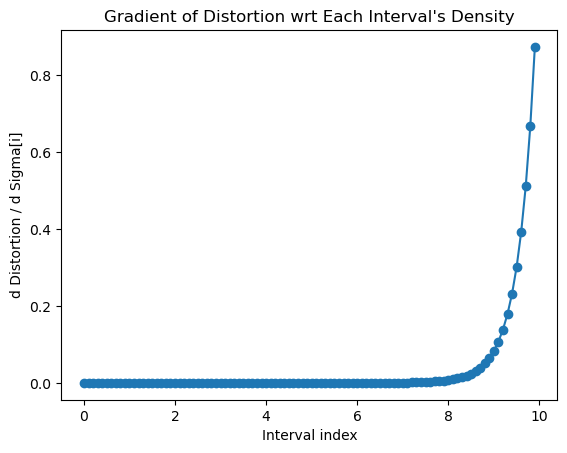

tensor(0.3250)


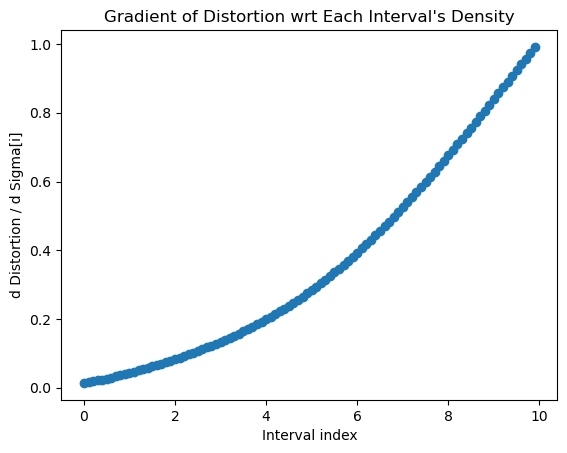

tensor(0.5500)


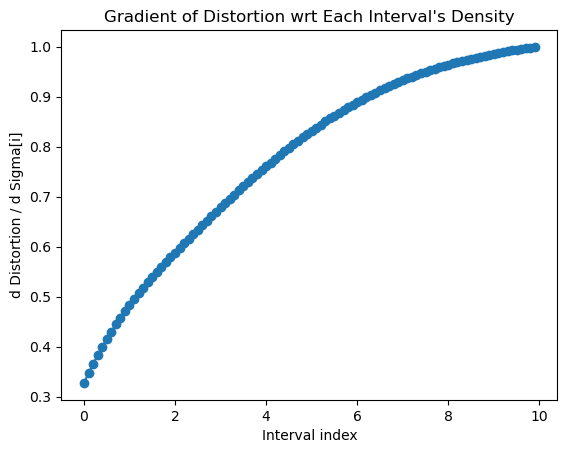

tensor(0.7750)


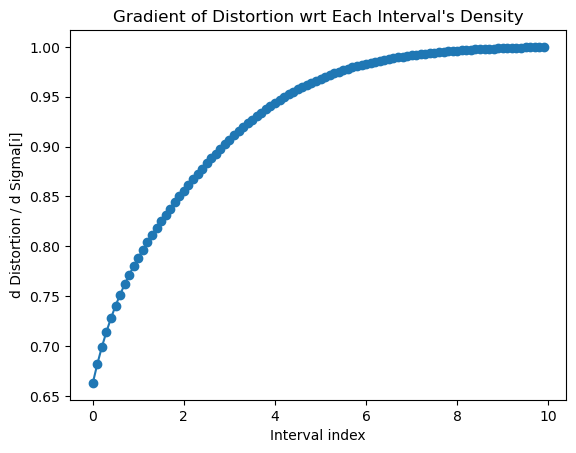

tensor(1.)


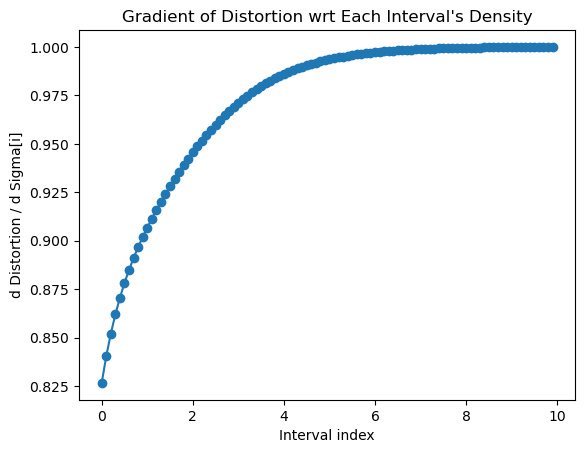

In [42]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def moment_0_int(a, b, s):
    return -torch.expm1(s * (a - b)) / s

def moment_1_int(a, b, s):
    if torch.abs(s) < 1e-5:
        return 0.5 * (b**2 - a**2)
    else:
        return -torch.expm1(s*(a - b)) / (s*s) + (a - b*torch.exp(s*(a - b))) / s;
        ds = s*(a - b)
        numer = a*s - (b*s + 1.0)*torch.exp(ds) + 1.0
        denom = s**2
        return numer / denom
def self_dist(a, b, s):
    # a, b, s can be scalars or tensors (of matching shapes)
    ds = s * (a - b)
    if (abs(ds) < 1e-4):
        return -1/3 * (a-b)**3
    else:
        denom = (s**3)
        numer = (2.0*ds*torch.exp(ds) - torch.expm1(2.0*ds)) / denom
        return numer

def update_distortion_state_int(state, t1, t2, sigma):
    """
    state = (x, y, z, w, v, T)
    t1, t2 = boundaries of interval
    sigma = density for this interval
    """
    x, y, z, w, v, T = state
    m0 = T * moment_0_int(t1, t2, sigma)
    m1 = T * moment_1_int(t1, t2, sigma)

    new_z = z + m0
    new_w = w + m1
    new_x = x + z*m1
    new_y = y + w*m0
    new_v = v + T*T*self_dist(t1, t2, sigma)

    alpha = 1 - torch.exp(-sigma*(t2 - t1))
    new_T = T * (1 - alpha)
    return (new_x, new_y, new_z, new_w, new_v, new_T)

def incremental_distortion(ts, sigmas):
    """
    ts: [N+1] boundaries
    sigmas: [N] piecewise-constant densities
    """
    # Initial state
    x = y = z = w = v = torch.zeros((), dtype=ts.dtype, device=ts.device)
    T = torch.ones((), dtype=ts.dtype, device=ts.device)

    state = (x, y, z, w, v, T)
    for i in range(len(sigmas)):
        state = update_distortion_state_int(state, ts[i], ts[i+1], sigmas[i])

    x, y, _, _, v, _ = state
    return 2*(x - y) + v


def main(sigma):
    # 1) Define 100 intervals on [0,1]
    N = 100
    ts = torch.linspace(0, 10, steps=N+1, requires_grad=False)

    # 2) Define uniform densities, each set to 1.0
    #    Make sure 'requires_grad=True' so we can differentiate
    sigmas = sigma*torch.ones(N)
    sigmas.requires_grad=True

    # 3) Compute distortion
    dist_val = incremental_distortion(ts, sigmas)

    # 4) Autodiff w.r.t. sigmas
    dist_val.backward()

    # sigmas.grad now holds d(dist_val)/d(sigmas[i])
    grads = sigmas.grad.detach().cpu().numpy()

    # 5) Plot the gradient
    plt.figure()
    plt.title("Gradient of Distortion wrt Each Interval's Density")
    plt.xlabel("Interval index")
    plt.ylabel("d Distortion / d Sigma[i]")
    plt.plot(ts[:-1], np.exp(grads), marker='o')
    # plt.plot(ts[:-1], np.log(1-grads), marker='o')
    # plt.plot(ts[:-1], 1-torch.exp(-sigma*ts[:-1]), marker='o')
    # plt.plot(ts[:-1], self_dist(0, ts[:-1], sigma), marker='o')
    plt.show()

if __name__ == "__main__":
    for s in torch.linspace(1e-1, 1, 5):
        print(s)
        main(s)
